# EDA, Wrangling, and Initial Preprocessing

To start, I was choosing between these datasets:
* Customer Support on Twitter https://www.kaggle.com/thoughtvector/customer-support-on-twitter
* Ubuntu Dialogue Corpus https://www.kaggle.com/rtatman/ubuntu-dialogue-corpus
* Relational Services in Customer Service (RSICS) https://nextit-public.s3-us-west-2.amazonaws.com/rsics.html

Since I am making a chatbot for helping with application problems, the following block defines the format of intents I want to classify as the keys. The values are the predefined responses that I might want to put. This is just a toy example to illustrate this concept for context. The unsupervised learning happens in the following notebook, this notebook is just to apply my wrangling and entire preprocessing pipeline and familiarize myself with my data.

In [1]:
print("Versions")
# Data science
import pandas as pd
print(f"Pandas: {pd.__version__}")
import numpy as np
print(f"Numpy: {np.__version__}")

# Visualization 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)
from bokeh.io import output_file, show
from bokeh.plotting import figure
from bokeh.models import ColorBar, ColumnDataSource
from bokeh.colors import Color

# Making my visualizations pretty
sns.set_style('whitegrid')

# Cool text visualization
import scattertext as st

# Regular Expressions
import re
print(f're: {re.__version__}')

# Preprocessing
import spacy
print(f'spaCy: {spacy.__version__}')
import nltk
print(f'nltk: {nltk.__version__}')
from spellchecker import SpellChecker
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import casual_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import yaml

# Emoji analysis and language detection
from spacymoji import Emoji
import spacy_cld
# For the counter
from collections import Counter

# Cool progress bars
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()  # Enable tracking of execution progress

Versions
Pandas: 1.0.5
Numpy: 1.18.5


/opt/anaconda3/envs/chatbot/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


re: 2.2.1
spaCy: 2.3.0
nltk: 3.5


/opt/anaconda3/envs/chatbot/lib/python3.7/site-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/opt/anaconda3/envs/chatbot/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Twitter
I ended up settling with the Twitter data (see comparison at the back of this notebook if you're interested in why) in order to get my labelled data.

Notes about dataset:
* It's from 2017 to 2018
* From another Kernel I saw that AmazonSupport contained the most tweets, and amazingly, it turns out, not all of the tweets are in English!

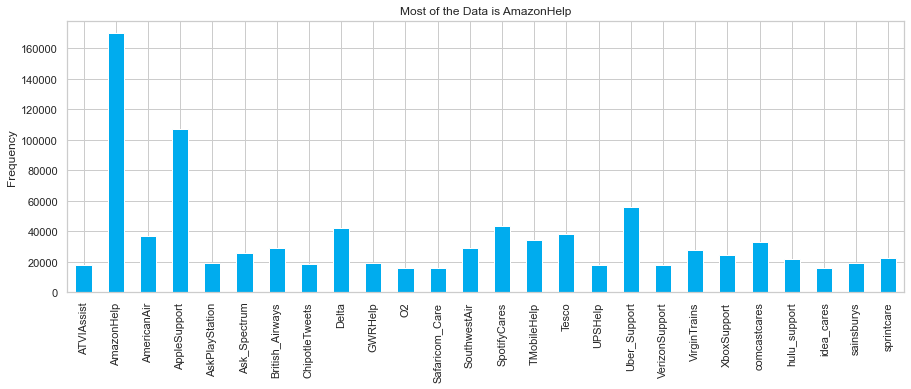

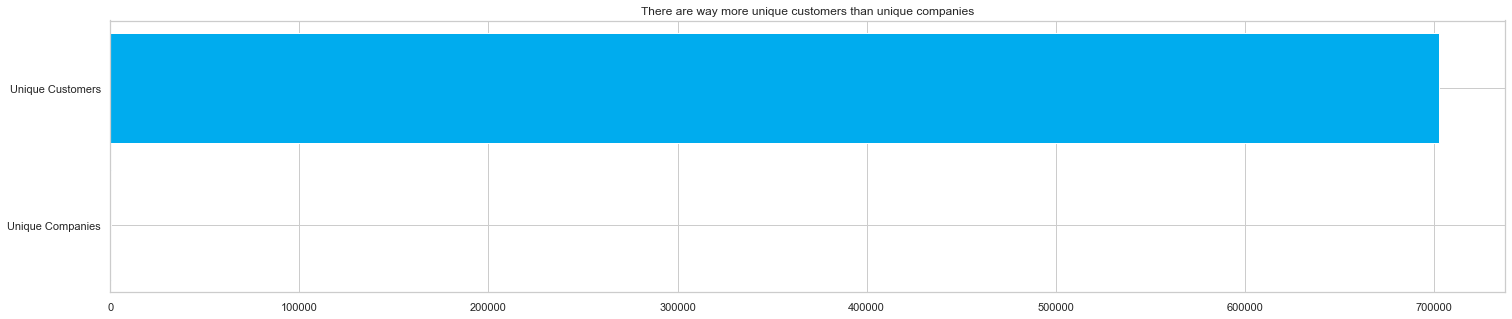

CPU times: user 12.5 s, sys: 2.31 s, total: 14.8 s
Wall time: 18.1 s


In [2]:
%%time
# Reading in all the Twitter data
all_data = pd.read_csv('data/twitter/twcs.csv')

# Finding the distribution of all authors
count = all_data.groupby("author_id")["text"].count()

# Showing only the authors that appear more than 15000 times
c = count[count>15000].plot(kind='bar',figsize=(15, 5), color='#00acee')
c.set_xlabel('')
c.set_ylabel('Frequency')
plt.title('Most of the Data is AmazonHelp')

# Saving my plot
plt.savefig('visualizations/authors.png')

plt.show()

# There are 108 unique authors that are companies and 702669 customers
authors_count = (len(all_data[all_data.inbound == False].author_id.unique()), len(all_data[all_data.inbound == True].author_id.unique()))

# Visualizing it
plt.figure(figsize =(25,5))
x = ['Unique Companies','Unique Customers']
ax = plt.barh(x, authors_count, color = '#00acee')
plt.title('There are way more unique customers than unique companies')
plt.show()

## Data Dictionary:
* Tweet_id: The unique ID for this tweet
* Author_id: The unique ID for this tweet author (anonymized for non-company users)
* Inbound: Whether or not the tweet was sent (inbound) to a company
* Created_at: When the tweet was created
* Text: The text content of the tweet
* Response_tweet_id: The tweet that responded to this one, if any
* In_response_to_tweet_id: The tweet this tweet was in response to, if any

In [3]:
# All data shape
print('All data has shape {}'.format(all_data.shape))

# Converting columns to the right datatypes
all_data['text'] = all_data['text'].astype('string')
all_data['author_id'] = all_data['author_id'].astype('string')

# This function utilizes Panda's Style to helps me encode data type and 
# magnitude information to my dataframe view
show = lambda x: x.tail(5).style.set_properties(**{'background-color': 'black',                                                   
                                    'color': 'lawngreen',                       
                                    'border-color': 'white'})\
.applymap(lambda x: f"color: {'lawngreen' if isinstance(x,str) else 'red'}")\
.background_gradient(cmap='Blues')

show(all_data)

All data has shape (2811774, 7)


,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
2811769,2987947,sprintcare,False,Wed Nov 22 08:43:51 +0000 2017,"@823869 Hey, we'd be happy to look into this for you. Please send us a Direct Message, so that we can further assist you. -TN",nan,2987948.000000
2811770,2987948,823869,True,Wed Nov 22 08:35:16 +0000 2017,@115714 wtf!? I’ve been having really shitty service all day !! Get your shit together!,2987947,nan
2811771,2812240,121673,True,Thu Nov 23 04:13:07 +0000 2017,"@143549 @sprintcare You have to go to https://t.co/v2tMHeTL7Q and ask them to add the Hulu service to your account. After you get the text, you’re good to go to https://t.co/gFyUq1kJTK",nan,2812239.000000
2811772,2987949,AldiUK,False,Wed Nov 22 08:31:24 +0000 2017,"@823870 Sounds delicious, Sarah! 😋 https://t.co/7uQPwyH1B6",nan,2987950.000000
2811773,2987950,823870,True,Tue Nov 21 22:01:04 +0000 2017,@AldiUK warm sloe gin mince pies with ice cream - the best thing ever! #notjustxmas#allyearround,"2987951,2987949",nan


You can see some data types are off, like the float.

# Data Wrangling

**Requirements**:
* **Inbound**: Since the first step I want to achieve is intent classification and to figure out what the customer is saying to the company, I only want data that goes from the customer to the company (inbound data). 
* **Just Apple data:** My first modeling step is to do some form of clustering to classify the intents for each of these tweets, doing so might be easier and more fruitful if I narrow the data to just the apple data because they will be in a somewhat similar domain. I can expand this over to other datasets.
* **First Tweet**

Later, I would like my chatbot to be able to respond to make *follow up* responses to my customers.

In [9]:
apple_data = all_data[all_data['author_id'] == 'AppleSupport']
apple_data.shape

(106860, 7)

There are 106860 rows of Apple data, which is 3.8 percent of the entire data. These are all data from Apple to a customer, I want the data from the customer to Apple for each of these Apple customer service responses, and this can be found in the reponse_tweet_id.

Now I drop the rows with a NaN value for the in response to tweet id column, meaning that the original customer inquiry was not available for that interaction

In [10]:
apple_data.dropna(subset = ['in_response_to_tweet_id'],inplace = True)
apple_data['inbound'].value_counts(), apple_data.shape

(False    106719
 Name: inbound, dtype: int64,
 (106719, 7))

Nice, it seems like we still have plenty of data to work with (106719 rows).

All of this is inbound data, because it's authored by Apple. Now I want to find all the original tweets from the customer to Apple Support and return them as a text in the Dataframe as opposed to an ID.

In other words, I change ```in_response_to_tweet_id``` from it's ID to it's text so we can see the what customer question this Apple Support Tweet was responding to.

In [11]:
# Converting the IDs to integers to match the tweet_id column for joining
apple_data.in_response_to_tweet_id = apple_data.in_response_to_tweet_id.astype('int64')

# Doing an inner join to get the respective tweets back from the all_data from and get the response texts
apple_data = pd.merge(all_data[['tweet_id','text']],apple_data,left_on='tweet_id', right_on='in_response_to_tweet_id')

# Dropping the columns that doesn't encode useful information and renaming the columns nicely for intepretability
apple_data.drop(['tweet_id_x','tweet_id_y','in_response_to_tweet_id','inbound'], axis = 1, inplace = True)

# Renaming the columns for intepretability
apple_data.rename(columns = {'text_x':'inbound_text','text_y':'outbound_text'},inplace = True)

# Subsetting to inbound and outbound data
text = apple_data[['inbound_text','outbound_text']]

# Previewing
print(text.head())

# Saving the real, raw inbound data
text.to_pickle('objects/raw_text.pkl')

inbound = text['inbound_text']
outbound = text['outbound_text']

# Unpacking helps me expand my data at each row for inspection
# [*text['outbound']]

                                        inbound_text  \
0  @AppleSupport The newest update. I️ made sure ...   
1             @AppleSupport  https://t.co/NV0yucs0lB   
2  @AppleSupport Tried resetting my settings .. r...   
3  @AppleSupport This is what it looks like https...   
4  @AppleSupport I️ have an iPhone 7 Plus and yes...   

                                       outbound_text  
0  @115854 Lets take a closer look into this issu...  
1  @115854 We're here for you. Which version of t...  
2  @115855 Let's go to DM for the next steps. DM ...  
3  @115855 Any steps tried since it started last ...  
4  @115855 That's great it has iOS 11.1 as we can...  


In [12]:
# Showing the results of data wrangling
show(apple_data)

,inbound_text,author_id,created_at,outbound_text,response_tweet_id
106643,"anyone having issues with #osx #HighSierra and #Slack, #zoom or Multiple monitors? Getting major lag. @115858 @118190 @172377 #DevLife",AppleSupport,Wed Nov 22 01:02:29 +0000 2017,"@823737 We're happy to help out with your concerns. To begin, have you made sure that all apps are up-to-date via the App Store > Updates tab? Does the slower performance happen with a specific pattern? Send us a DM and we'll work on this together. https://t.co/GDrqU22YpT",2987500
106644,Hey @AppleSupport - not being able to duplicate a file in #pages when you searched for it is really annoying. What’s the fix?? https://t.co/CqnGyqNsLZ,AppleSupport,Wed Nov 22 02:33:58 +0000 2017,"@689907 We're certainly glad to get you pointed in the right direction! Please reach out in DM and let us know which iPad model you're using and the version of iOS installed, as well as which country you're tweeting from. https://t.co/GDrqU22YpT",nan
106645,Yo @AppleSupport is that weird glitch w/ the capital “I️” your attempt to make my tweets less about me? I️,AppleSupport,Wed Nov 22 02:29:26 +0000 2017,"@823765 We'd love to help! Which device are you using? The latest versions of iOS include a fix for unexpected results with Auto-Correction while typing. If you haven't had a chance, we advise backing up and updating. Here's a guide to help: https://t.co/ahjigcvFRG",nan
106646,What the fuck @AppleSupport my phone keeps hanging up calls and showing “call failure” 🤬😡,AppleSupport,Wed Nov 22 03:27:30 +0000 2017,@823779 We'd like to help. Send us a DM and we can start there. https://t.co/GDrqU22YpT,nan
106647,Is anyone having #iphone issues with there phone freezing randomly I have the 7 pulse updated to iOS 11.2 the newest version. Wtf is going on???? 🤬😡🤬😡🤬 @115858 @AppleSupport #whycan’tyouguysgetitright #stopmakingnewphonesuntillyoulearntomaketheoldonerunrite,AppleSupport,Wed Nov 22 04:15:29 +0000 2017,@823796 We'd love to offer our help in making sure your iPhone is working at peak performance. Send us a DM and let us know if you are using iOS 11.1.2 or iOS 11.2. You can confirm in Settings > General > About. https://t.co/GDrqU2kzhr,nan


Sweet. So now we are going to build off this `apple_data` from this point on.

Since we are working with unsupervised learning for the first part of my chatbot, I do not need to do a train test split. My test set would also just end up needing labels as well. For this reason, I will just subset my data to the inbound/outbound data without employing the concept of unseen data.

In [14]:
# Just making for the nice display
show = lambda x: x.head(5).style.set_properties(**{'background-color': 'black',                                                   
                                    'color': 'lawngreen',                       
                                    'border-color': 'white'})\
.applymap(lambda x: f"color: {'lawngreen' if isinstance(x,str) else 'red'}")\
.background_gradient(cmap='Blues')

# Displaying processed_text
display = pd.DataFrame({"Inbound": inbound, "Processed Inbound": 
                        list(processed_inbound) + [''] * (len(inbound) - len(processed_inbound)),
                       "Outbound": outbound})

show(display)

NameError: name 'processed_inbound' is not defined

This outbound data will be useful for natural langauge generation, and I might want to store the id where it points to as well.

When we process this outbound data for natural langauge generation, would this have a different preprocessing steps? Would we want it to have more complete sentences so maybe we would not try to remove the actual stop words and punctuation.

# Text Preprocessing Pipeline
In this process, it's expected that I will find much edge cases, and I don't have to address them all. However, in the end, I felt like my preprocessing pipeline is relatively complete given this dataset.

Also, this was an iterative process because I fit my models in the next notebook just to notice that my Tweets still had '\u200d', '#', '', and '@' even though I still did a lot of fitting already. These are just emojis and extra punctuation I decided at a later stage to remove, but in the end I just modified my pipeline function. 

Before that, I did a bit of EDA with bag of words to see what words are being used the most by the dataset to better preprocess the data and prevent working in too much granularity. 

In [15]:
# Writing a function to plot the counts that are in the data

def top10_bagofwords(data, output_name, title):
    ''' Taking as input the data and plots the top 10 words based on counts in this text data'''
    bagofwords = CountVectorizer()
    inbound = bagofwords.fit_transform(data)
    inbound # Output will be a sparse matrix
    # Inspecting of often contractions and colloquial language is used
    word_counts = np.array(np.sum(inbound, axis=0)).reshape((-1,))
    words = np.array(bagofwords.get_feature_names())
    words_df = pd.DataFrame({"word":words, 
                             "count":word_counts})
    words_rank = words_df.sort_values(by="count", ascending=False)
    # words_rank.to_csv('words_rank.csv') # Storing it in a csv so I can inspect and go through it myself
    words_rank.head()
    # Visualizing top 10 words
    plt.figure(figsize=(12,6))
    sns.barplot(words_rank['word'][:10], words_rank['count'][:10].astype(str), palette = 'inferno')
    plt.title(title)
    
    # Saving
    plt.savefig(f'visualizations/{output_name}.png')
    
    plt.show()

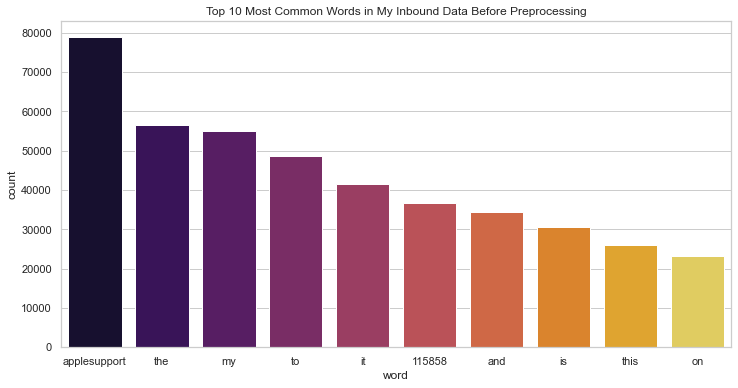

In [16]:
top10_bagofwords(inbound, 'most_common_before' ,'Top 10 Most Common Words in My Inbound Data Before Preprocessing')

We see that after preprocessing, we will remove the handles which is what applesupport and 115858 is in the visualization above. For now, I briefly visualized the top 10 most common tokens to show that my data as it currently is quite dirty, they will definitely skew and ruin my results if I don't do preprocessing!

### Emoji Analysis
You can leave emojis in and have model learn embeddings for the emojis. Emoji are used in very specific instances, if they use emojis it will be in a useful sense. If the emojis are used for inside jokes, then it's different story, but that is likely not the case for this dataset because these are customer service tweets.

There's actually an embedding called emoji2vec, but that's something I can explore down the line. Right now, I think doc2vec won't be able to handle these emojis in the best way and it might skew my results if I leave them in.

Extracted from [this kernel](https://www.kaggle.com/psbots/customer-support-meets-spacy-universe)

In [17]:
import en_core_web_lg

# This works, I couldn't load the en_core_web_lg
nlp = spacy.load('en')
emoji = Emoji(nlp, merge_spans=False)
nlp.add_pipe(emoji, first=True)
print(nlp.pipe_names)

# This is a list that stores all the emojis
# Make sure to have your processed_inbound ready. I used an intermediate version
# of my processed data. Or you can run this after you've run my preprocessing
# pipeline below.

# processed_inbound.progress_apply(" ".join)
emojis = []
for doc in tqdm(nlp.pipe(inbound, batch_size=512)):
    if doc._.has_emoji:
        for e in doc._.emoji:
            emojis.extend(e[0])

# Let's count them
emoji_count = Counter(emojis)
emoji_count.most_common(30)

['emoji', 'tagger', 'parser', 'ner']


/opt/anaconda3/envs/chatbot/lib/python3.7/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


[('😡', 3069),
 ('🙄', 1463),
 ('😭', 1100),
 ('\u200d', 966),
 ('️', 960),
 ('🤔', 959),
 ('😒', 830),
 ('😤', 780),
 ('🤬', 750),
 ('😩', 699),
 ('🏻', 685),
 ('🤦', 622),
 ('🙃', 549),
 ('♀', 537),
 ('🏼', 530),
 ('🏽', 479),
 ('♂', 454),
 ('😑', 438),
 ('😂', 365),
 ('🏾', 329),
 ('🤷', 321),
 ('👎', 315),
 ('👍', 280),
 ('😫', 269),
 ('😐', 261),
 ('😠', 252),
 ('📱', 236),
 ('☹', 226),
 ('🙏', 196),
 ('😔', 194)]

Let's visualize the emojis as well and export it as png

In [18]:
from bokeh.io import export_png

# Let's store it in a list, so we can remove it from the Pipeline above
unique_emojis = [i[0] for i in emoji_count]

# Also storing the counts in a list. Skipping irrelevant, unintepretable ones.
plotted_emojis = [i[0] for i in emoji_count.most_common(30)]
plotted_emojis = plotted_emojis[:3] + plotted_emojis[5:]
counts = [i[1] for i in emoji_count.most_common(30)]
counts = counts[:3] + counts[5:]

# Using Bokeh because pyplot doesn't show emojis
# Run this cell to view the html visualization

output_file("visualizations/emojis.html")


p = figure(x_range=plotted_emojis, plot_height=600, plot_width = 1300, title="Emoji Counts",
           toolbar_location=None, tools="")
p.vbar(x=plotted_emojis, top=counts, width=0.9, color = "#FBD043")
p.xgrid.grid_line_color = None
p.y_range.start = 0

export_png(p, filename="visualizations/emojis.png")

show(p)

AttributeError: 'Figure' object has no attribute 'head'

In [ ]:
filename = "visualizations/emojis.html"
IFrame(src=filename, width = 800, height=700)

Here we mostly see negative emojis! Meaning that most of the sentiment of the customers are complaints or inquiries!

For now, I will remove the emojis, however in the future it might be interesting to do stuff with these emojis! Or, as an alternative I might leave only the most informative and common ones, maybe like the top 10 that clearly expresses a sentiment - which is something that will be related to an intent.

In [57]:
# Building my own tokenizer 

### Variable storage
punct_base = ['?']

# Punctuations I want to remove, including the empty token
puncts = ['\u200d','?', '....','..','...','','@','#', ',', '.', '"', ':', ')', '(', '-', '!', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '*', '+', '\\', 
    '•', '~', '£', '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', 
    '½', 'à', '…', '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', 
    '—', '‹', '─', '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 
    'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', 
    '¹', '≤', '‡', '√', '!','🅰','🅱']

# Using NLTK's stop words corpus
stopwords.words('english');
stop_words = set(stopwords.words('english')) 

# Found a dictionary of common contractions and colloquial language
contraction_colloq_dict = {"btw": "by the way", "ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have"}

# Initializing the lemmatizer
lemmatizer = nltk.stem.WordNetLemmatizer()

import emoji # For emoji removal step

import en_core_web_sm
try:
    # Initializing spaCy objects (Don't run this more than once)
    nlp_cld = spacy.load('en',disable_pipes=["tagger","ner"])
    language_detector = spacy_cld.LanguageDetector()
    nlp_cld.add_pipe(language_detector)
except ValueError as e:
    print("The spaCy function was run more than once, but that's okay because it means it was initialized!")

## My Entire Preliminary Text Preprocessing Pipeline

I wanted to all the preprocessing to be an iterative process, so I compiled it all in one function so that it all runs at the same time and so there is an enhanced sense of organization. At every preprocessing step, I visualize the lengths of each tokens at the data. In general, things like removing stop-words will shift the distribution to the left because we have fewer and fewer tokens at every preprocessing step. I also provide a peek to the head of the data at each step so that it clearly shows what processing is being done at each step.

In [89]:
# My preprocessing functions (defining them here so that I could access them from anywhere in the notebook)

def visualize_lengths(data,title):
    '''Visualizing lengths of tokens in each tweet'''
    lengths = [len(i) for i in data]
    plt.figure(figsize=(13,6))
    plt.hist(lengths, bins = 40)
    plt.title(title)
    plt.show()
    
def remove_from_list(x, stuff_to_remove) -> list:
        ''' Making a function to remove a list of items from a list'''
        for item in stuff_to_remove:
            # Making sure to iterate through the entire token
            for i,token in enumerate(x):
                if item == token:
                    del x[i]
        return x
    
def remove_links(doc):
    return [re.sub(r'^https?:\/\/.*[\r\n]*', '', token, flags=re.MULTILINE) for token in doc]

def correct_spellings(x):
    ''' Takes as input a list and outputs a list of the corrected spelling'''
    corrected_text = []
    for word in x:
        if word in x:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return corrected_text

def replace_from_dict(x,dic):
    ''' Making a function to replace all the items in a list based on a dictionary. I made sure to use the insert
            method to insert the longer-gram replacement as distinct items in the list at that specific index'''
    replaced_counter = 0
    for item in dic.items():
        for i, e in enumerate(x):
            if e == item[0]:
                replaced_counter+=1
                    # Inserting the expanded tokens in a way that preserves the order
                del x[i]
                for ix, token in enumerate(item[1].split()):
                    x.insert(i+ix,token)
#         print(f"Amount of words replaced: {replaced_counter}")
    return x    

def only_english(x):
    ''' Making a function that only accepts English by appending True if it is English and False otherwise 
            into a mask. Returns a mask'''    
    mask = []
    x = x.apply(" ".join)
    try:
        for i,doc in tqdm(enumerate(nlp_cld.pipe(x, batch_size=512))):
            if 'en' not in doc._.languages or len(doc._.languages) != 1:
                mask.append(False)
            else:
                mask.append(True)
    except Exception as e:
        print(f"Exception:{e}")
    return mask

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)
    
def lemmatize_list(x):
    ''' This lemmatizer function should work on a single list of tokenized data'''
#         # Turning list into a string
    x = " ".join(x)
    # Returning a list again
    return [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(x)]

def extract_emojis(s):
        return [c for c in s if c not in emoji.UNICODE_EMOJI]

def limit_length(x, max_tokens, min_tokens):
    ''' Inputs a list and drops it out of the document if 
        the document has more than the max and less than the min'''
    output = x
    if len(x) > max_tokens:
        output = np.nan
    if len(x) <= min_tokens:
        output = np.nan
    return output

def clean_numbers(x):
    for i,j in enumerate(x):
        if bool(re.search(r'\d', j)):
            del x[i]
    return x

def validate(func, locals):
    ''' Validating a function below to accept correct input'''
    for var, test in func.__annotations__.items():
        value = locals[var]
        try: 
            pr=test.__name__+': '+test.__docstring__
        except AttributeError:
            pr=test.__name__   
        msg = '{}=={}; Test: {}'.format(var, value, pr)
        assert test(value), msg

# End to end tokenizer function

def my_tokenizer(data: lambda _data: isinstance(_data, pd.Series)) -> 'Cleaned Pandas Series':
    ''' I am making my own end-to-end tokenizer function for preprocessing that accepts
    a Pandas Series as input and outputs a preprocessed Pandas Series'''
    
    # Making sure input is a series (these are two ways of doing the same thing)
    assert isinstance(data,pd.Series), 'Input must be a Pandas Series'
#     validate(my_tokenizer, locals())
    
    # 1. Converting all to lower case
    data = data.str.lower()
    
    print(f'1. Original shape of data is {data.shape}')
    
    
    # 2. Tokenizing with NLTK's TweetTokenizer. This limits repeated characters to 
    # three with the reduce lens paramater and strips all the @'s. It also
    # splits it into 1-gram tokens
    tknzr = TweetTokenizer(strip_handles = True, reduce_len = True)
    # Using progress apply to show the progress bar
    data = data.progress_apply(tknzr.tokenize)
    
    print(f'2. Tokenized, removed handles, and reduced the length of repeated characters.\
          \n Shape is still {data.shape}. \n \n Peek: \n {data.head()}')
    visualize_lengths(data, 'Length of Tokens after Step 2')
    
    # 3. Removing the punctuation
    
    data = data.progress_apply(remove_from_list, stuff_to_remove = puncts)
    print(f'3. Removed empty tokens and punctuation. Shape is still {data.shape}. \n \n Peek: \n {data.head()}')
    visualize_lengths(data, 'Length of Tokens after Step 9')
    
    # 3.1. Removing links
    
    data = data.progress_apply(remove_links)
    
    print(f'3. Removed the links. Shape is still {data.shape}. \n \n Peek: \n {data.head()}')
    visualize_lengths(data, 'Length of Tokens after Step 3')

    # 4. Checking for and correcting mispellings
    spell = SpellChecker()
    
    # Skipping this step first because it takes way too long
#     data = data.progress_apply(correct_spellings)
    
    print(f'4. Applied automispelling corrections. Shape is still {data.shape}. \n \n Peek: \n {data.head()}')
    
    
    # 5. Removing the stop words, utilizing the same remove_from_list function defined above
    
    data = data.progress_apply(remove_from_list, stuff_to_remove = stop_words)
    
    print(f'5. Removed the stop words. Shape is still {data.shape}. \n \n Peek: \n {data.head()}')
    visualize_lengths(data, 'Length of Tokens after Step 4')
    
    # 6. Expanding contractions and colloquial language
    
    data = data.progress_apply(replace_from_dict, dic = contraction_colloq_dict)
    print(f'6. Expanded contractions into extra tokens. Shape is still {data.shape}. \n \n Peek: \n {data.head()}')
    visualize_lengths(data, 'Length of Tokens after Step 5')
    
    # 7. Removing non-english Tweets with spaCy

    data = data[only_english(data)]
    print(f'7. Remove all non-english Tweets. Shape is now {data.shape}. Clearly less than before! \n \n Peek: \n {data.head()}')
    
    # 8. Lemmatization

    data = data.progress_apply(lemmatize_list)
    print(f'8. Lemmatized the tokens. Shape is still {data.shape}. \n \n Peek: \n {data.head()}')
    visualize_lengths(data, 'Length of Tokens after Step 8')   
   
    # Removing again to make sure I get everything
    data = data.progress_apply(remove_from_list, stuff_to_remove = puncts)

    # 9.1. Removing emojis -- (UPDATE) in a way that preserves Series indexes
    
    unique_emojis = [i[0] for i in emoji.UNICODE_EMOJI]
    data = data.apply(remove_from_list, stuff_to_remove = unique_emojis)
    
    # 9.2. Removing numbers -- (UPDATE) also in a way that preserves Series indexes
    # Using nested list comprehension
    data = data.progress_apply(clean_numbers)
    
    print(f'9. Removed emojis and numbers. Shape is still {data.shape}. \n \n Peek: \n {data.head()}')
    visualize_lengths(data, 'Length of Tokens after Step 9')   
    
    # 10. Limiting length of Tweet
    max_tokens = 50
    min_tokens = 5
    data = data.progress_apply(limit_length, min_tokens = min_tokens, max_tokens = max_tokens)
    # Dropping all nan values, which are the token limits that didn't meet the thresholding requirements
    data = data.dropna()
    print(f'10. Limited each tweet to a max of {max_tokens} tokens and a min of {min_tokens} tokens. Shape is now {data.shape}. \n \n Peek: \n {data.head()}')
    visualize_lengths(data, 'Length of Tokens after Step 10')
    
    return data
    

1. Original shape of data is (106648,)



2. Tokenized, removed handles, and reduced the length of repeated characters.          
 Shape is still (106648,). 
 
 Peek: 
 0    [the, newest, update, ., i️, made, sure, to, d...
1                            [https://t.co/nv0yucs0lb]
2    [tried, resetting, my, settings, .., restartin...
3    [this, is, what, it, looks, like, https://t.co...
4    [i️, have, an, iphone, 7, plus, and, yes, i️, do]
Name: inbound_text, dtype: object


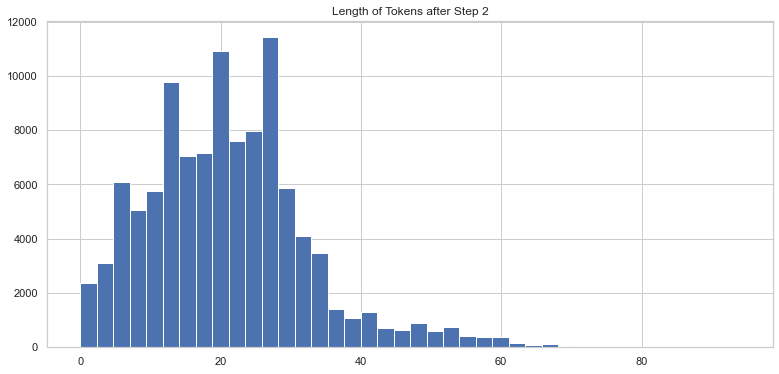


3. Removed empty tokens and punctuation. Shape is still (106648,). 
 
 Peek: 
 0    [the, newest, update, i️, made, sure, to, down...
1                            [https://t.co/nv0yucs0lb]
2    [tried, resetting, my, settings, restarting, m...
3    [this, is, what, it, looks, like, https://t.co...
4    [i️, have, an, iphone, 7, plus, and, yes, i️, do]
Name: inbound_text, dtype: object


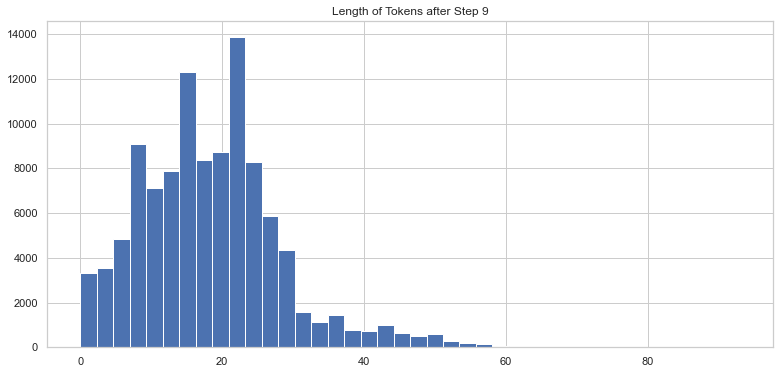


3. Removed the links. Shape is still (106648,). 
 
 Peek: 
 0    [the, newest, update, i️, made, sure, to, down...
1                                                   []
2    [tried, resetting, my, settings, restarting, m...
3                  [this, is, what, it, looks, like, ]
4    [i️, have, an, iphone, 7, plus, and, yes, i️, do]
Name: inbound_text, dtype: object


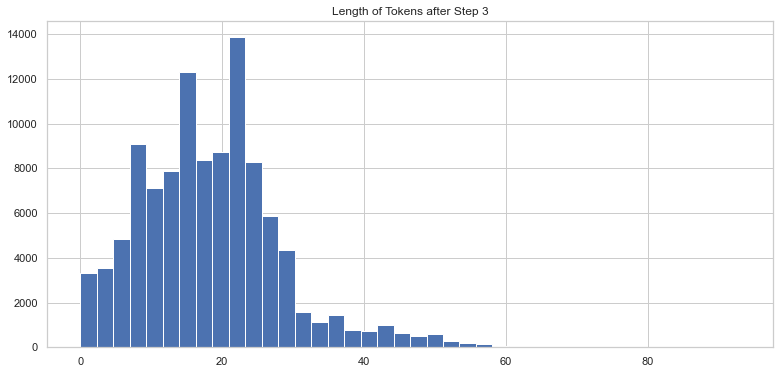

4. Applied automispelling corrections. Shape is still (106648,). 
 
 Peek: 
 0    [the, newest, update, i️, made, sure, to, down...
1                                                   []
2    [tried, resetting, my, settings, restarting, m...
3                  [this, is, what, it, looks, like, ]
4    [i️, have, an, iphone, 7, plus, and, yes, i️, do]
Name: inbound_text, dtype: object



5. Removed the stop words. Shape is still (106648,). 
 
 Peek: 
 0    [newest, update, i️, made, sure, download, yes...
1                                                   []
2      [tried, resetting, settings, restarting, phone]
3                                      [looks, like, ]
4                       [i️, iphone, 7, plus, yes, i️]
Name: inbound_text, dtype: object


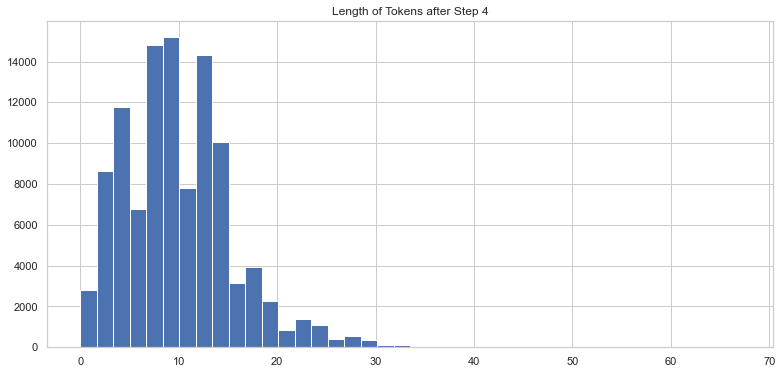


6. Expanded contractions into extra tokens. Shape is still (106648,). 
 
 Peek: 
 0    [newest, update, i️, made, sure, download, yes...
1                                                   []
2      [tried, resetting, settings, restarting, phone]
3                                      [looks, like, ]
4                       [i️, iphone, 7, plus, yes, i️]
Name: inbound_text, dtype: object


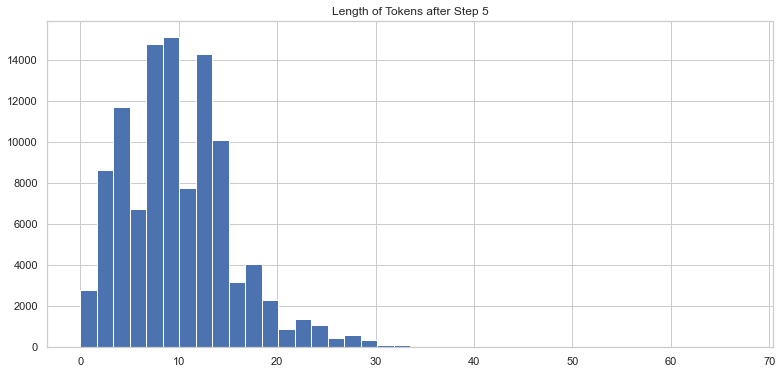

/opt/anaconda3/envs/chatbot/lib/python3.7/site-packages/ipykernel_launcher.py:54: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



7. Remove all non-english Tweets. Shape is now (93391,). Clearly less than before! 
 
 Peek: 
 0    [newest, update, i️, made, sure, download, yes...
2      [tried, resetting, settings, restarting, phone]
4                       [i️, iphone, 7, plus, yes, i️]
5                     [i️, need, answers, annoying, 🙃]
6    [hey, anyone, else, upgraded, ios, 11.1, issue...
Name: inbound_text, dtype: object



8. Lemmatized the tokens. Shape is still (93391,). 
 
 Peek: 
 0    [new, update, i️, make, sure, download, yester...
2                [try, reset, setting, restart, phone]
4                       [i️, iphone, 7, plus, yes, i️]
5                         [i️, need, answer, annoy, 🙃]
6    [hey, anyone, else, upgraded, io, 11.1, issue,...
Name: inbound_text, dtype: object


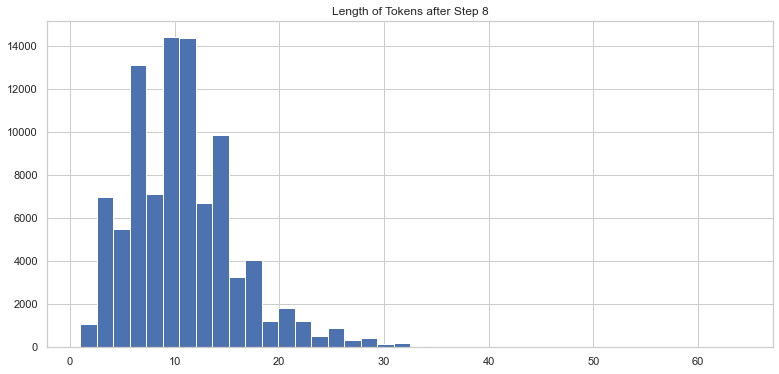


9. Removed emojis and numbers. Shape is still (93391,). 
 
 Peek: 
 0    [new, update, i️, make, sure, download, yester...
2                [try, reset, setting, restart, phone]
4                          [i️, iphone, plus, yes, i️]
5                            [i️, need, answer, annoy]
6    [hey, anyone, else, upgraded, io, issue, capit...
Name: inbound_text, dtype: object


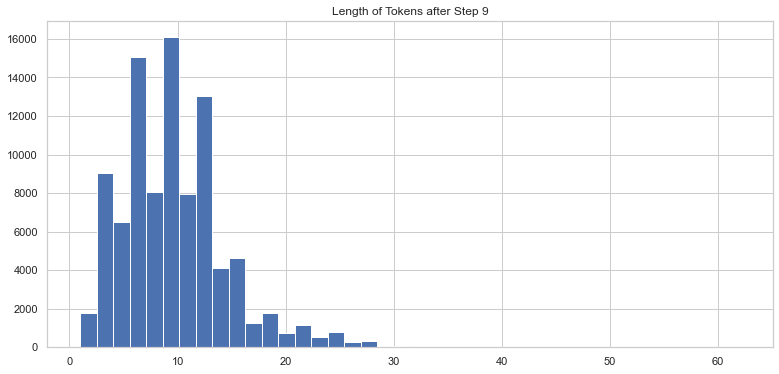


10. Limited each tweet to a max of 50 tokens and a min of 5 tokens. Shape is now (76066,). 
 
 Peek: 
 0     [new, update, i️, make, sure, download, yester...
6     [hey, anyone, else, upgraded, io, issue, capit...
12    [hello, internet, someone, explain, symbol, ke...
13    [get, screenshot, say, iphonex, reserve, email...
15    [thank, update, phone, even, slow, barely, wor...
Name: inbound_text, dtype: object


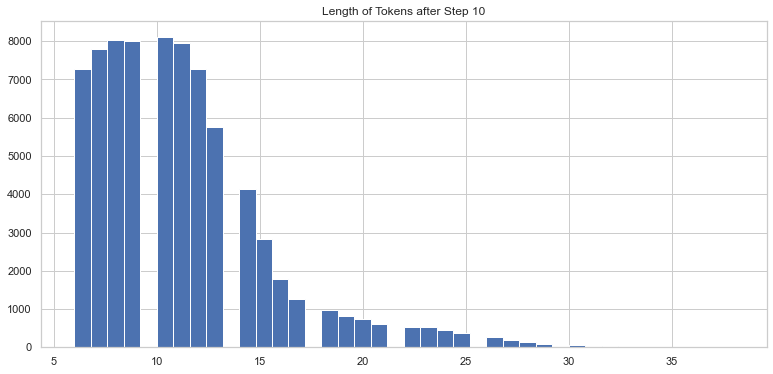

In [91]:
processed_inbound = my_tokenizer(text['inbound'])

This is great, we now have the preprocessed data stored into the variable ```processed_inbound```. Now let's convert this processed data to pkl so that I don't have to run this over and over again to use at the next notebook.

In [92]:
processed_inbound.head()

0     [new, update, i️, make, sure, download, yester...
6     [hey, anyone, else, upgraded, io, issue, capit...
12    [hello, internet, someone, explain, symbol, ke...
13    [get, screenshot, say, iphonex, reserve, email...
15    [thank, update, phone, even, slow, barely, wor...
Name: inbound_text, dtype: object

In [98]:
# Index matching
real_inbound = text['inbound_text'].loc[processed_inbound.index]
real_outbound = text['outbound_text'].loc[processed_inbound.index]
processed_inbound

# Storing in DataFrame
processed = pd.DataFrame({'Processed Inbound': processed_inbound, 'Real Inbound': real_inbound,
             'Real Outbound': real_outbound})

# Preview
processed.head()

,Processed Inbound,Real Inbound,Real Outbound
0,"[new, update, i️, make, sure, download, yester...",@AppleSupport The newest update. I️ made sure ...,@115854 Lets take a closer look into this issu...
6,"[hey, anyone, else, upgraded, io, issue, capit...",Hey @AppleSupport and anyone else who upgraded...,"@115856 Hey, let's work together to figure out..."
12,"[hello, internet, someone, explain, symbol, ke...","Hello, internet. Can someone explain why this ...",@115861 You're in the right place; we'll do al...
13,"[get, screenshot, say, iphonex, reserve, email...",@AppleSupport I’ve got a screenshot saying my ...,@115863 Go ahead and send us a DM please. Let ...
15,"[thank, update, phone, even, slow, barely, wor...",Thank you @AppleSupport I updated my phone and...,"@115864 We'd like to help, but we'll need more..."


In [99]:
# Saving processed inbound data into a serialized saved file
processed_inbound.to_pickle('objects/processed_inbound.pkl')

# Saving all processed data
processed.to_pickle('objects/processed.pkl')

In [7]:
# Loading it back in
processed_inbound = pd.read_pickle('objects/processed_inbound.pkl')
processed_inbound.head()

0     [new, update, i️, make, sure, download, yester...
4     [hey, anyone, else, upgraded, io, issue, capit...
9     [hello, internet, someone, explain, symbol, ke...
10    [get, screenshot, say, iphonex, reserve, email...
12    [thank, update, phone, even, slow, barely, wor...
dtype: object

# Unit testing for preprocessing pipeline, with brief explanations

Feel free to skip through this part if you would like. This is where I individually tested each preprocessing step above and commented on some considerations I made at each step. At the end of this section, I also briefly show some other things I considered when I preprocessed my data.

### 1. Removing numbers

I also want to make sure mine takes out 11.1 because that's just noise.

In [46]:
'1'.isdigit()

True

In [62]:
processed_inbound

0         [new, update, i️, make, sure, download, yester...
2             [try, reset, setting, .., restart, phone, ..]
4                            [i️, iphone, 7, plus, yes, i️]
6         [hey, anyone, else, upgraded, io, 11.1, issue,...
10                   [hello, line, close, tonight, #, help]
                                ...                        
106643    [anyone, issue, #, osx, #, highsierra, #, slac...
106644    [hey, able, duplicate, file, #, page, search, ...
106645    [yo, weird, glitch, w, capital, i️, attempt, m...
106646    [fuck, phone, keep, hang, call, show, call, fa...
106647    [anyone, #, iphone, issue, phone, freeze, rand...
Name: inbound_text, Length: 79760, dtype: object

In [52]:
test = ['1', 'i', 'dont', 'want', 'numbers', '12', '44','11.1']

no_ints = [x for x in test if not any(c.isdigit() for c in x)]

no_ints

['i', 'dont', 'want', 'numbers']

In [58]:
# Nested list comprehensions to apply it to the entire series
# [[x for x in i if not any(c.isdigit() for c in x)] for i in processed_inbound]

### 2. Testing out the TweetTokenizer

In [33]:
test = " ".join(['@KingJames','I','am', 'the', '#GOAT'])

In [34]:
tknzr = TweetTokenizer(strip_handles = True, reduce_len = True)
# Using progress apply to show the progress bar
tknzr.tokenize(test)

['I', 'am', 'the', '#GOAT']

So now I know that this tokenizer does not take out #, so I will add it on 

### 3. Removing stuff from a list 

In [93]:
test = ['', 'bye', 'empty', 'string']

In [94]:
def remove_from_list(x, stuff_to_remove):
    ''' Making a function to remove a list of items from a list'''
    for item in stuff_to_remove:
        # Making sure to iterate through the entire token
        for i,token in enumerate(x):
            if item == token:
                del x[i]
    return x

In [95]:
remove_from_list(test, puncts)

['bye', 'empty', 'string']

### 3.1 Removing links
Going to be doing this with a regular expression.

In [40]:
test = processed_X_train[0:10]
test;

In [37]:
def remove_links(doc):
    return [re.sub(r'^https?:\/\/.*[\r\n]*', '', token, flags=re.MULTILINE) for token in doc]

In [41]:
test.apply(remove_links);

### 4. Testing out the Spell Checker

In [86]:
test = ['Cna','you', 'twy', 'to', 'spel', 'check','and','fux', 'tihs','ios']

spell = SpellChecker()
def correct_spellings(x):
    ''' Takes as input a list and outputs a list of the corrected spelling'''
    corrected_text = []
    for word in x:
        if word in x:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return corrected_text
        
text = "speling correctin"
correct_spellings(test)

['can', 'you', 'two', 'to', 'spell', 'check', 'and', 'fun', 'this', 'ios']

So here we see that the function generally does a good job, however it miscorrected twy as try and fux as fix because it doesn't understand context and uses Levianathon distance as it's measure of incorrectly spelt words, but that's okay and generally I think it'll do a good job as a preprocessing step. But it is too slow.

### 6. Testing contraction and colloquial langauge expansion step

In [178]:
def replace_from_dict(x,dic):
    ''' Making a function to replace all the items in a list based on a dictionary. I made sure to use the insert
        method to insert the longer-gram replacement as distinct items in the list at that specific index'''
    x = x.str.lower() 
    x = list(x)
    replaced_counter = 0
    for item in dic.items():
        for i, e in enumerate(x):
            if e == item[0]:
                replaced_counter+=1
                # Inserting the expanded tokens in a way that preserves the order
                del x[i]
                for ix, token in enumerate(item[1].split()):
                    x.insert(i+ix,token)
    print(f"Amount of words replaced: {replaced_counter}")
    return pd.Series(x)

trial = pd.Series(["Ain't","nobody","is","as", "cute", "as", "you"])
replace_from_dict(trial,contraction_dict)

Amount of words replaced: 1


0        is
1       not
2    nobody
3     loves
4       you
dtype: object

### 7. Testing out removing non-english Tweets
I will be using an extension in the spaCy-universe called spaCy-CLD, which uses Naive Bayes and n-grams as a language classifer. That's pretty cool. Good thing I only have to load it in as a package here! I think it's also more efficient than a language detection module I tried earlier, which took me 2+ hours to apply to my data! Gotta love the work they did for optimization.

Extension attributes in spaCy allow you store additional information that are relevant to the application. It's quite a powerful tool. 

Todo: See what the langdetector was trained on.

In [53]:
# I will assume that I already initialized the spaCy objects, as shown in the code cell up top

In [76]:
def only_english(x):
    ''' Making a function that only accepts English by appending True if it is English and False otherwise 
        into a mask. Returns a mask'''    
    mask = []
    x = x.apply(" ".join)
    try:
        for i,doc in tqdm(enumerate(nlp_cld.pipe(x, batch_size=512))):
            if 'en' not in doc._.languages or len(doc._.languages) != 1:
                mask.append(False)
            else:
                mask.append(True)
    except Exception as e:
        print(f"Exception:{e}")
    return mask

In [45]:
# Demonstrating and experimenting what a doc object is
doc = nlp_cld(X_train[0])
print(doc)
print(doc._.languages)  
print(doc._.language_scores)

@AppleSupport The newest update. I️ made sure to download it yesterday.
['en']
{'en': 0.98}


### 8. Testing out the WordNetLemmatizer 

This following lemmatizer tries to break down the word down to it's lemma or dictionary form.

In [59]:
# Initialize spacy 'en' model, keeping only tagger component needed for lemmatization
nlp = spacy.load('en', disable=['parser', 'ner'])

sentence = "James is good, but Eko beats him at coding Python so is he really?"

# Parse the sentence using the loaded 'en' model object `nlp`
doc = nlp(sentence)

# Extract the lemma for each token and join
[token.lemma_ for token in doc]
#> 'the strip bat be hang on -PRON- foot for good'

['the', 'stripe', 'bat', 'be', 'hang', 'on', '-PRON-', 'foot', 'for', 'good']

In [ ]:
# Lemmatize with POS Tag

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [55]:
# This function returns the POS
get_wordnet_pos('cool')

'n'

In [65]:
# 1. Init Lemmatizer
lemmatizer = WordNetLemmatizer()

# 2. Lemmatize Single Word with the appropriate POS tag
word = 'feet'
print(lemmatizer.lemmatize(word, get_wordnet_pos(word)))

# 3. Lemmatize a Sentence with the appropriate POS tag
sentence = "James is good at coding python, but Eko is even better at coding"
print([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(sentence)])

foot
['James', 'be', 'good', 'at', 'cod', 'python', ',', 'but', 'Eko', 'be', 'even', 'well', 'at', 'cod', 'it']


In [31]:
lemmatizer = nltk.stem.WordNetLemmatizer()
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()

test = ['This','is','a','row']

def lemmatize_text(x):
    ''' This lemmatizer f`unction should work on a single list of tokenized data'''
    # Turning list into a string
    x = " ".join(x)
    # Returning a list again
    return [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(x)]

Failed to catch the past tense of a verb.

In [48]:
trial = processed_inbound.iloc[1:10]
trial

2         [try, reset, setting, .., restart, phone, ..]
6     [hey, anyone, else, upgraded, io, 11.1, issue,...
10               [hello, line, close, tonight, #, help]
12    [hello, internet, someone, explain, symbol, ke...
13    [get, screenshot, say, #, iphonex, reserve, 3r...
15    [thank, update, phone, even, slow, barely, wor...
19    [need, software, update, urgently, battery, la...
21         [hi, go, youtube, lose, do, thanks, support]
25    [hey, last, time, download, update, freak, pho...
Name: inbound_text, dtype: object

In [100]:
trial.progress_apply(lemmatize_text)

26943    [work, apple, support, get, result, paid, deve...
18403    [many, stupid, bug, new, update, ready, throw,...
19883    [take, 7, plus, charger, get, ready, work, tim...
87560    [log, itunes, account, lap-fucking-top, god, g...
23736            [oh, sorry, meant, attach, screenshot, 🙄]
72623    [ever, since, update, iphone, bluetooth, stay,...
11613                [fuck, phone, say, sim, need, answer]
6323     [think, there, be, bug, io, 11, someone, sends...
66978    [nothing, work, last, update., can, not, open,...
Name: inbound_text, dtype: object

iOS is still lemmatized wrong, but that is alright because all the instances of iOS will still be together.

### 9. Removing Emojis

In [107]:
test = pd.Series([['😤', '🙍','🎲', '🙃', 'get', 'rid', 'of', '😐','emojis'],['This', 'No','Emoji']], index = [6,9])
test

6    [😤, 🙍, 🎲, 🙃, get, rid, of, 😐, emojis]
9                        [This, No, Emoji]
dtype: object

In [102]:
# Redefining
def remove_from_list(x, stuff_to_remove):
    ''' Making a function to remove a list of items from a list'''
    for item in stuff_to_remove:
        # Making sure to iterate through the entire token
        for i,token in enumerate(x):
            if item == token:
                del x[i]
    return x

In [103]:
import emoji

def extract_emojis(s):
    return [c for c in s if c in emoji.UNICODE_EMOJI]

In [116]:
unique_emojis = [i[0] for i in emoji.UNICODE_EMOJI]
test.apply(remove_from_list, stuff_to_remove = unique_emojis)

6    [get, rid, of, emojis]
9         [This, No, Emoji]
dtype: object

### 10. Limiting the length of each tweet
Based on the distribution of the tokens we have been seeing at each step above, I think a good cutoff point would be at 50 tokens. I am going to try something like 75 or 100 because you generally don't want to drop too much data. If you don't drop the data, when you use Keras tokenizer and pad sequences, if it's longer than 100 words it will stop there.

Similarly, I want to filter out documents with a number of tokens that are less than a particular threshold.

In [63]:
# Creating toy list of length 100
test = ['test'] * 100
test = pd.Series([test, ['Another','one']])
test

0    [test, test, test, test, test, test, test, tes...
1                                       [Another, one]
dtype: object

In [67]:
def limit_length(x, max_tokens, min_tokens):
    ''' Inputs a list and drops it out of the document if 
    it has more than the max and less than the min'''
    output = x
    if len(x) > max_tokens:
        output = np.nan
    if len(x) < thres:
        output = np.nan
    return output

## Alternative Steps
Ones that I did not include in my Pipeline for a specific reason, but I still employed or considered.

### 2. Cleaning the numbers with regular expressions

In [72]:
test = pd.Series([['1','iPhone','is','2','little'],['help','1','please']])

In [81]:
def clean_numbers(x):
    for i,j in enumerate(x):
        if bool(re.search(r'\d', j)):
            del x[i]
    return x

In [82]:
test = test.apply(clean_numbers)
test

0    [iPhone, is, little]
1          [help, please]
dtype: object

In [65]:
test

0         1
1    iPhone
2        is
3         2
4    little
dtype: object

### 3. N Grams
Pairs are always better usually.

# Other Datasets I Explored:

These are just the two other datasets that I explored. I did not use the Ubuntu one because I did not like the language that the customer's spoke here and I don't think it is not ideal to merge it with by my Twitter Apple inbound data.

As for the RSICS data, it's interesting because it also had some data that encodes some relational information of the customer (I ultimately want my chatbot to have a relational aspect to it as well, so it is not a bland chatbot), but I am not interested in travel and plane customer data so I did not use this.

## Ubuntu

In [39]:
# Reading in Ubuntu data
df = pd.read_csv('data/Ubuntu-dialogue-corpus/dialogueText.csv')

In [40]:
# Visualizing the tables, applying styling so that the table is more readable
show = lambda x: x.tail(50).style.set_properties(**{'background-color': 'black',                                                   
                                    'color': 'lawngreen',                       
                                    'border-color': 'white'})\
.applymap(lambda x: f"color: {'lawngreen' if isinstance(x,str) else 'red'}")\
.background_gradient(cmap='Blues')

In [41]:
show(df)

,folder,dialogueID,date,from,to,text
1038274,3,91347.tsv,2012-01-19T00:41:00.000Z,natschil,xiambax,where?
1038275,3,91347.tsv,2012-01-19T00:41:00.000Z,natschil,xiambax,i'm guessing gconf....
1038276,3,272273.tsv,2006-10-31T10:36:00.000Z,ben_,nan,as in some of my RAM is bad?
1038277,3,272273.tsv,2006-10-31T10:38:00.000Z,ben_,nan,i upgraded to edgy
1038278,3,272273.tsv,2006-10-31T10:40:00.000Z,kbrosnan,ben_,are you using any plugins? about:plugins in the address bar that can also cause both to be crashy in the same way
1038279,3,253128.tsv,2009-02-17T06:31:00.000Z,hlm,nan,ermmm I suppose im going to reinstall ubuntu for the 5th time in less than 48 hours :'(
1038280,3,253128.tsv,2009-02-17T06:32:00.000Z,blouf,hlm,: have you tried to customize usplash ?
1038281,3,253128.tsv,2009-02-17T06:34:00.000Z,blouf,hlm,: have you tried to customize usplash ?
1038282,3,84896.tsv,2009-01-13T18:30:00.000Z,EdgeX-,nan,Hello; What program would you recommend for me as far as video editing goes?
1038283,3,84896.tsv,2009-01-13T18:31:00.000Z,EdgeX-,nan,thanks jrib :)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038324 entries, 0 to 1038323
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   folder      1038324 non-null  int64 
 1   dialogueID  1038324 non-null  object
 2   date        1038324 non-null  object
 3   from        1038311 non-null  object
 4   to          566035 non-null   object
 5   text        1038237 non-null  object
dtypes: int64(1), object(5)
memory usage: 47.5+ MB


In [16]:
df['text']

0          Hello folks, please help me a bit with the fol...
1          Did I choose a bad channel? I ask because you ...
2          the second sentence is better english   and we...
3                                               Sock Puppe?t
4                                                       WTF?
                                 ...                        
1038319                                           anyone on?
1038320                                                  yes
1038321    can I get a pastebin of someones menu.lst with...
1038322                         http://pastebin.com/fe921690
1038323                                               thanks
Name: text, Length: 1038324, dtype: object

## Relational Services in Customer Service (RSICS)

In [16]:
!ls data/rsics_dataset

1_1_align.csv                     5_4_align.csv
1_2_align.csv                     6_1_align.csv
1_3_align.csv                     6_2_align.csv
1_4_align.csv                     6_3_align.csv
2_1_align.csv                     6_4_align.csv
2_2_align.csv                     7_1_align.csv
2_3_align.csv                     7_2_align.csv
2_4_align.csv                     7_3_align.csv
3_1_align.csv                     7_4_align.csv
3_2_align.csv                     8_1_align.csv
3_3_align.csv                     8_2_align.csv
3_4_align.csv                     8_3_align.csv
4_1_align.csv                     8_4_align.csv
4_2_align.csv                     LICENSE.md
4_3_align.csv                     README.md
4_4_align.csv                     all_data_by_threshold.csv
5_1_align.csv                     all_multi_intent.csv
5_2_align.csv                     rsics.bib
5_3_align.csv                     tagged_selections_by_sentence.csv


In [18]:
pd.read_csv('data/rsics_dataset/1_2_align.csv')

,Annotator A ID,Annotator B ID,Parition ID,Corpora ID,Sentence ID,Text,Annotator A Text,Annotator B Text,Length,Error,Alignment Score,Agreement
0,1,7.000000,2.0,2.0,7506.0,what is the price for round trip between toron...,what is the price for round trip between toron...,what is the price for round trip between toron...,61.0,0.0,1.000000,1.0
1,1,7.000000,2.0,2.0,7507.0,trying to find a good deal and good timing to ...,trying to find a good deal and good timing to ...,[trying to find a ]good deal and good timing t...,81.0,17.0,0.790123,0.0
2,1,7.000000,2.0,2.0,7509.0,trying to plan route penn ny to montgomery ny....,trying to plan route penn ny to montgomery ny....,trying to plan route penn ny to montgomery ny....,63.0,16.0,0.746032,0.0
3,1,7.000000,2.0,2.0,7510.0,"Hi does the 54 Vermonter train go from Newark,...",[Hi ]does the 54 Vermonter train go from Newar...,[Hi ]does the 54 Vermonter train go from Newar...,87.0,10.0,0.885057,1.0
4,1,7.000000,2.0,2.0,7511.0,is there a train service from los angeles ca t...,is there a train service from los angeles ca t...,is there a train service from los angeles ca t...,64.0,0.0,1.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2659,Average Length,97.922122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2660,Average Error,0.076430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2661,Average Alignment,0.923570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
